#### TO DO:
- Study RandCropByPosNegLabeld
- Hyperparameter Tuning for Unet
- Number of workers
- Normalization
- Spatial size set to 256: Full Pass!
- Are they using Softmax?


In [1]:
import logging
import os
import sys
import tempfile
from glob import glob

import torch
from PIL import Image
from torch.utils.tensorboard import SummaryWriter

import monai
from monai.data import create_test_image_2d, list_data_collate, decollate_batch, DataLoader
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.transforms import (
    Activations,
    EnsureChannelFirstd,
    AsDiscrete,
    Compose,
    LoadImaged,
    RandCropByPosNegLabeld,
    RandRotate90d,
    ScaleIntensityd,
    EnsureType,
)
from monai.visualize import plot_2d_or_3d_image
from pathlib import Path

In [2]:
import matplotlib.pyplot as plt

In [2]:
monai.config.print_config()
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

MONAI version: 0.9.0rc2+17.gdf4a7d7
Numpy version: 1.20.3
Pytorch version: 1.10.0+cu113
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: df4a7d72e1d231b898f88d92cf981721c49ceaeb
MONAI __file__: /scratch/scratch6/akansh12/env/lib/python3.7/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.8
Nibabel version: 3.1.1
scikit-image version: 0.18.3
Pillow version: 8.4.0
Tensorboard version: 2.7.0
gdown version: 4.5.1
TorchVision version: 0.11.1+cu113
tqdm version: 4.63.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.8.0
pandas version: 1.3.4
einops version: 0.4.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



Randomly making VAL SET

In [28]:
path2train_images = Path("/scratch/scratch6/akansh12/ravir_data/RAVIR Dataset/train/training_images/")
path2train_mask = Path("/scratch/scratch6/akansh12/ravir_data/ravir/data/training_images_masks/")
path2test_images = Path("/scratch/scratch6/akansh12/ravir_data/RAVIR Dataset/test/")

In [4]:
train_images = sorted(os.listdir(path2train_images))
train_mask = sorted(os.listdir(path2train_mask))

In [5]:
images = sorted(glob(os.path.join(path2train_images, "*.png")))
segs = sorted(glob(os.path.join(path2train_mask, "*.png")))
train_files = [{"img": img, "seg": seg} for img, seg in zip(images[:19], segs[:19])]
val_files = [{"img": img, "seg": seg} for img, seg in zip(images[19:], segs[19:])]

In [6]:
print(len(train_files), len(val_files))

19 4


#### Transforms

In [7]:
train_transforms = Compose(
    [
        LoadImaged(keys=["img", "seg"]),
        EnsureChannelFirstd(keys=["img", "seg"]),
        ScaleIntensityd(keys=["img", "seg"]),
        RandCropByPosNegLabeld(
            keys=["img", "seg"], label_key="seg", spatial_size=[256, 256], pos=1, neg=1, num_samples=8
        ),
        RandRotate90d(keys=["img", "seg"], prob=0.5, spatial_axes=[0, 1]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["img", "seg"]),
        EnsureChannelFirstd(keys=["img", "seg"]),
        ScaleIntensityd(keys=["img", "seg"]),
    ]
)

#### Dataloader

In [8]:
train_ds = monai.data.Dataset(data=train_files, transform=train_transforms)
train_loader = DataLoader(
    train_ds,
    batch_size=2,
    shuffle=True,
    num_workers=0,
    collate_fn=list_data_collate,
    pin_memory=torch.cuda.is_available(),
)
val_ds = monai.data.Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=0, collate_fn=list_data_collate)

In [30]:
for batch_data in train_loader:
    inputs, labels = batch_data["img"].to(device), batch_data["seg"].to(device)
    break
    

In [38]:
post_label = Compose([EnsureType(), AsDiscrete(to_onehot=3)])


In [40]:
labels = [post_label(i) for i in decollate_batch(labels)]

In [39]:
labels.shape

torch.Size([16, 1, 256, 256])

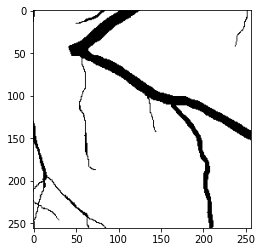

In [51]:
plt.imshow(labels[0][0].numpy(), cmap = 'gray')

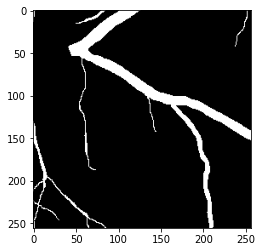

In [52]:
plt.imshow(labels[0][1].numpy(), cmap = 'gray')

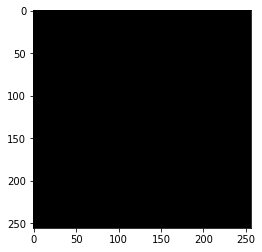

In [53]:
plt.imshow(labels[0][2].numpy(), cmap = 'gray')

In [34]:
out = model(inputs)

In [35]:
out.shape

torch.Size([16, 3, 256, 256])

#### Model

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = monai.networks.nets.UNet(
    spatial_dims=2,  #2D UNET
    in_channels=1,
    out_channels=3,  #Background, Artery, Veins
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

#### Metric

In [ ]:
dice_metric = DiceMetric(include_background=False, reduction="mean", get_not_nans=False)

In [ ]:
post_pred = AsDiscrete(argmax=True, to_onehot=3)


In [25]:
post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])


tensor([0.0000, 0.5020, 1.0000])

In [ ]:



def main(tempdir):
    monai.config.print_config()
    logging.basicConfig(stream=sys.stdout, level=logging.INFO)

    # create a temporary directory and 40 random image, mask pairs
    print(f"generating synthetic data to {tempdir} (this may take a while)")
    for i in range(40):
        im, seg = create_test_image_2d(128, 128, num_seg_classes=1)
        Image.fromarray((im * 255).astype("uint8")).save(os.path.join(tempdir, f"img{i:d}.png"))
        Image.fromarray((seg * 255).astype("uint8")).save(os.path.join(tempdir, f"seg{i:d}.png"))

    images = sorted(glob(os.path.join(tempdir, "img*.png")))
    segs = sorted(glob(os.path.join(tempdir, "seg*.png")))
    train_files = [{"img": img, "seg": seg} for img, seg in zip(images[:20], segs[:20])]
    val_files = [{"img": img, "seg": seg} for img, seg in zip(images[-20:], segs[-20:])]

    # define transforms for image and segmentation
    train_transforms = Compose(
        [
            LoadImaged(keys=["img", "seg"]),
            EnsureChannelFirstd(keys=["img", "seg"]),
            ScaleIntensityd(keys=["img", "seg"]),
            RandCropByPosNegLabeld(
                keys=["img", "seg"], label_key="seg", spatial_size=[96, 96], pos=1, neg=1, num_samples=4
            ),
            RandRotate90d(keys=["img", "seg"], prob=0.5, spatial_axes=[0, 1]),
        ]
    )
    val_transforms = Compose(
        [
            LoadImaged(keys=["img", "seg"]),
            EnsureChannelFirstd(keys=["img", "seg"]),
            ScaleIntensityd(keys=["img", "seg"]),
        ]
    )

    # define dataset, data loader
    check_ds = monai.data.Dataset(data=train_files, transform=train_transforms)
    # use batch_size=2 to load images and use RandCropByPosNegLabeld to generate 2 x 4 images for network training
    check_loader = DataLoader(check_ds, batch_size=2, num_workers=4, collate_fn=list_data_collate)
    check_data = monai.utils.misc.first(check_loader)
    print(check_data["img"].shape, check_data["seg"].shape)

    # create a training data loader
    train_ds = monai.data.Dataset(data=train_files, transform=train_transforms)
    # use batch_size=2 to load images and use RandCropByPosNegLabeld to generate 2 x 4 images for network training
    train_loader = DataLoader(
        train_ds,
        batch_size=2,
        shuffle=True,
        num_workers=4,
        collate_fn=list_data_collate,
        pin_memory=torch.cuda.is_available(),
    )
    # create a validation data loader
    val_ds = monai.data.Dataset(data=val_files, transform=val_transforms)
    val_loader = DataLoader(val_ds, batch_size=1, num_workers=4, collate_fn=list_data_collate)
    dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
    post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])
    # create UNet, DiceLoss and Adam optimizer
    
    loss_function = monai.losses.DiceLoss(sigmoid=True)
    optimizer = torch.optim.Adam(model.parameters(), 1e-3)

    # start a typical PyTorch training
    val_interval = 2
    best_metric = -1
    best_metric_epoch = -1
    epoch_loss_values = list()
    metric_values = list()
    writer = SummaryWriter()
    for epoch in range(10):
        print("-" * 10)
        print(f"epoch {epoch + 1}/{10}")
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:
            step += 1
            inputs, labels = batch_data["img"].to(device), batch_data["seg"].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            epoch_len = len(train_ds) // train_loader.batch_size
            print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
            writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                val_images = None
                val_labels = None
                val_outputs = None
                for val_data in val_loader:
                    val_images, val_labels = val_data["img"].to(device), val_data["seg"].to(device)
                    roi_size = (96, 96)
                    sw_batch_size = 4
                    val_outputs = sliding_window_inference(val_images, roi_size, sw_batch_size, model)
                    val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                    # compute metric for current iteration
                    dice_metric(y_pred=val_outputs, y=val_labels)
                # aggregate the final mean dice result
                metric = dice_metric.aggregate().item()
                # reset the status for next validation round
                dice_metric.reset()
                metric_values.append(metric)
                if metric > best_metric:
                    best_metric = metric
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(), "best_metric_model_segmentation2d_dict.pth")
                    print("saved new best metric model")
                print(
                    "current epoch: {} current mean dice: {:.4f} best mean dice: {:.4f} at epoch {}".format(
                        epoch + 1, metric, best_metric, best_metric_epoch
                    )
                )
                writer.add_scalar("val_mean_dice", metric, epoch + 1)
                # plot the last model output as GIF image in TensorBoard with the corresponding image and label
                plot_2d_or_3d_image(val_images, epoch + 1, writer, index=0, tag="image")
                plot_2d_or_3d_image(val_labels, epoch + 1, writer, index=0, tag="label")
                plot_2d_or_3d_image(val_outputs, epoch + 1, writer, index=0, tag="output")

    print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")
    writer.close()


if __name__ == "__main__":
    with tempfile.TemporaryDirectory() as tempdir:
        main(tempdir)